Modified based on official protocol: https://www.biotite-python.org/latest/examples/gallery/structure/modeling/model_lddt.html#sphx-glr-examples-gallery-structure-modeling-model-lddt-py

We use a uniprot code to find the experimental structure & sequence from PDB database as well as alphafold database to check if there is any difference.

Found 32 matching PDB chains for UniProt ID P16278.
Using PDB ID 3THC, chain A as reference structure.
['__abstractmethods__', '__add__', '__class__', '__copy_create__', '__copy_fill__', '__delattr__', '__delitem__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getitem__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setitem__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_annot', '_array_length', '_bonds', '_box', '_coord', '_copy_annotations', '_del_element', '_set_element', '_subarray', 'add_annotation', 'array_length', 'atom_name', 'bonds', 'box', 'chain_id', 'coord', 'copy', 'del_annotation', 'element', 'equal_annotation_categories', 'equal_annotations', 'get_annotation', 'get_annotation_categories', 'get_atom', 'hetero', 'ins_co

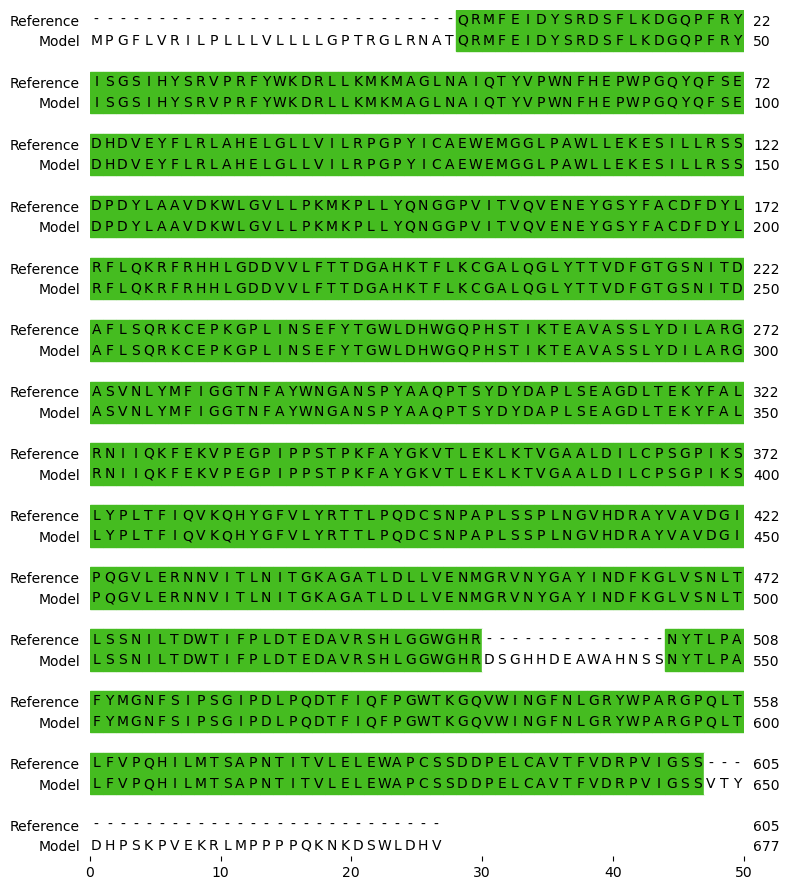

In [1]:
import biotite.structure.io as strucio
from biotite.structure.io.pdb import PDBFile
import numpy as np
from collections import defaultdict
import biotite.database.afdb as afdb
import biotite.database.rcsb as rcsb
import biotite.sequence as seq
import biotite.sequence.align as align
import biotite.structure as struc
import biotite.structure.io.pdbx as pdbx
import matplotlib.pyplot as plt
import biotite.sequence.graphics as graphics

# Uniprot ID of the protein of interest (in this case human beta-galactosidase)
# Cleaves beta-linked terminal galactosyl residues from gangliosides, glycoproteins, and glycosaminoglycans.
UNIPROT_ID = "P16278"

## Get the reference experimental structure from the PDB
query = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=UNIPROT_ID,
)

# The UniProt ID is defined for a single chain
ids = rcsb.search(query, return_type="polymer_instance")
print(f"Found {len(ids)} matching PDB chains for UniProt ID {UNIPROT_ID}.")

# Simply use the first matching chain as reference (see more thorough selection in the following block)
pdb_id, chain_id = ids[0].split(".")
print(f"Using PDB ID {pdb_id}, chain {chain_id} as reference structure.")

pdb_file = PDBFile.read(rcsb.fetch(pdb_id, "pdb"))

reference = pdb_file.get_structure(model=1)

print(dir(reference))
reference = reference[reference.chain_id == chain_id]
# The experimental structure may contain additional small molecules
# (e.g. water, ions etc.) that are not part of the predicted structure
reference = reference[struc.filter_amino_acids(reference)]


## Get the predicted structure from AlphaFold DB
model = PDBFile.read(afdb.fetch(UNIPROT_ID, "pdb")).get_structure(model=1)

## Filter the structures to common atoms that are present in both structures
print(f"struc.to_sequence(reference): {struc.to_sequence(reference)}")
reference_sequence = struc.to_sequence(reference)[0][0]
model_sequence = struc.to_sequence(model)[0][0]

# Get BLOSUM62 matrix
identity_matrix = align.SubstitutionMatrix.std_protein_matrix()

# Perform pairwise sequence alignment with affine gap penalty
# Terminal gaps are not penalized
alignment = align.align_optimal(
    reference_sequence,
    model_sequence,
    # Residues might be missing due to experimental reasons but not due to homology
    identity_matrix,
    gap_penalty=-1,
    terminal_penalty=False,
    max_number=1,
)[0]

# Draw first and only alignment
# The color intensity indicates the similiarity
fig = plt.figure(figsize=(8.0, 9.0))
ax = fig.add_subplot(111)
graphics.plot_alignment_similarity_based(
    ax,
    alignment,
    matrix=identity_matrix,
    labels=["Reference", "Model"],
    show_numbers=True,
    show_line_position=True,
)
fig.tight_layout()

plt.show()

Obviously only pick up the first found structure is a bit too simple, here is a better script which consider all 32 sequeces and pick up the best one.

In [2]:
# A much more thorough analysis would consider all matching PDB structures

import numpy as np
from biotite.structure.io.pdb import PDBFile
import biotite.structure as struc
import biotite.database.rcsb as rcsb
import biotite.sequence.align as align

# -----------------------------
# Helper: extract AA sequence from AtomArray
# -----------------------------
def atomarray_to_protein_sequence(atom_array):
    """
    Convert a structure AtomArray to a ProteinSequence.
    biotite.struc.to_sequence() returns (sequences, start_indices).
    For single-chain AtomArray, sequences is typically a list with one ProteinSequence.
    """
    seqs, starts = struc.to_sequence(atom_array)
    # seqs can contain multiple sequences if multiple chains are present
    # If you've already filtered to one chain, seqs[0] is your sequence object
    return seqs[0]

# -----------------------------
# Helper: score a candidate PDB chain against model sequence
# -----------------------------
def score_candidate(reference_seq, model_seq, matrix):
    """
    Align reference sequence to model sequence and compute basic summary metrics.

    Returns:
        coverage: fraction of model positions aligned to a residue (not a gap) in reference
        mismatch_rate: fraction of aligned residue-residue positions that are non-identical
        internal_gap_count: number of gap runs inside the reference (proxy for missing segments)
        alignment: the biotite alignment object
    """
    # Use an alignment that's lenient about terminal gaps
    aln = align.align_optimal(
        reference_seq,
        model_seq,
        matrix,
        gap_penalty=-1,
        terminal_penalty=False,
        max_number=1
    )[0]

    # biotite alignments can be inspected via the trace / sequences
    # We'll convert to strings for easier logic (works fine for protein sequences)
    ref_str = str(reference_seq)
    mod_str = str(model_seq)

    # alignment.get_gapped_sequences() gives gapped strings in alignment space
    gapped = aln.get_gapped_sequences()
    ref_gapped = gapped[0]
    mod_gapped = gapped[1]

    # Coverage: among model residues, how many positions are aligned to a residue in reference?
    # i.e., positions where model is not '-' AND reference is not '-'
    model_res_positions = np.array([c != '-' for c in mod_gapped])
    ref_has_residue = np.array([c != '-' for c in ref_gapped])
    overlap = model_res_positions & ref_has_residue
    coverage = overlap.sum() / model_res_positions.sum()

    # Mismatch rate among overlap positions
    overlap_idxs = np.where(overlap)[0]
    if len(overlap_idxs) == 0:
        mismatch_rate = 1.0
    else:
        mismatches = sum(ref_gapped[i] != mod_gapped[i] for i in overlap_idxs)
        mismatch_rate = mismatches / len(overlap_idxs)

    # Internal gap runs in reference sequence (excluding terminal gaps)
    # This is a crude proxy for "this structure is missing internal segments"
    # We'll count runs of '-' that occur after the first residue and before the last residue.
    ref_gapped_arr = np.array(list(ref_gapped))
    non_gap_positions = np.where(ref_gapped_arr != '-')[0]
    if len(non_gap_positions) == 0:
        internal_gap_count = 999
    else:
        left = non_gap_positions[0]
        right = non_gap_positions[-1]
        interior = ref_gapped_arr[left:right+1]
        # Count transitions into gap runs: pattern where interior[i] == '-' and interior[i-1] != '-'
        internal_gap_count = 0
        for i in range(1, len(interior)):
            if interior[i] == '-' and interior[i-1] != '-':
                internal_gap_count += 1

    return coverage, mismatch_rate, internal_gap_count, aln


# -----------------------------
# Main: evaluate all candidate PDB chains
# -----------------------------
UNIPROT_ID = "P16278"

query = rcsb.FieldQuery(
    "rcsb_polymer_entity_container_identifiers.reference_sequence_identifiers.database_accession",
    exact_match=UNIPROT_ID,
)

ids = rcsb.search(query, return_type="polymer_instance")
print(f"Found {len(ids)} matching PDB chains for UniProt ID {UNIPROT_ID}.")

# Load AFDB model once
from biotite.database.afdb import fetch as af_fetch
model = PDBFile.read(af_fetch(UNIPROT_ID, "pdb")).get_structure(model=1)
model = model[struc.filter_amino_acids(model)]
model_seq = atomarray_to_protein_sequence(model)

# Substitution matrix - you used std_protein_matrix()
# (note: in biotite this is a standard protein matrix; often BLOSUM62-like)
matrix = align.SubstitutionMatrix.std_protein_matrix()

results = []

for inst in ids:
    pdb_id, chain_id = inst.split(".")
    try:
        pdb_file = PDBFile.read(rcsb.fetch(pdb_id, "pdb"))
        structure = pdb_file.get_structure(model=1)

        # Focus on that chain
        chain = structure[structure.chain_id == chain_id]
        chain = chain[struc.filter_amino_acids(chain)]

        # If chain becomes empty (e.g., no amino acids), skip
        if len(chain) == 0:
            continue

        ref_seq = atomarray_to_protein_sequence(chain)

        coverage, mismatch, gap_runs, aln = score_candidate(ref_seq, model_seq, matrix)

        # Simple ranking score:
        # prioritize high coverage, low mismatch, low internal gaps
        # You can tune weights depending on your goal.
        score = (coverage * 1.0) - (mismatch * 0.5) - (gap_runs * 0.05)

        results.append({
            "pdb_id": pdb_id,
            "chain_id": chain_id,
            "coverage": coverage,
            "mismatch_rate": mismatch,
            "internal_gap_runs": gap_runs,
            "score": score,
            "alignment": aln,   # keep if you want to inspect later
            "ref_seq_len": len(ref_seq),
        })

    except Exception as e:
        # Network hiccups or parsing issues can occur; skip those entries
        continue

# Sort best-first
results = sorted(results, key=lambda x: x["score"], reverse=True)

# Print top candidates
for r in results[:10]:
    print(
        f"{r['pdb_id']}.{r['chain_id']}  "
        f"score={r['score']:.3f}  "
        f"coverage={r['coverage']:.3f}  "
        f"mismatch={r['mismatch_rate']:.3f}  "
        f"gap_runs={r['internal_gap_runs']}  "
        f"ref_len={r['ref_seq_len']}"
    )

# Choose the best candidate as reference
best = results[0]
print("\nBest reference candidate:", best["pdb_id"], best["chain_id"])

# load best reference structure
pdb_id = best["pdb_id"]
chain_id = best["chain_id"]
print(f"Using PDB ID {pdb_id}, chain {chain_id} as reference structure.")
pdb_file = PDBFile.read(rcsb.fetch(pdb_id, "pdb"))
reference = pdb_file.get_structure(model=1)
reference = reference[reference.chain_id == chain_id]


Found 32 matching PDB chains for UniProt ID P16278.
3THC.A  score=0.844  coverage=0.894  mismatch=0.000  gap_runs=1  ref_len=605
3THC.B  score=0.844  coverage=0.894  mismatch=0.000  gap_runs=1  ref_len=605
3THD.A  score=0.844  coverage=0.894  mismatch=0.000  gap_runs=1  ref_len=605
3THD.B  score=0.844  coverage=0.894  mismatch=0.000  gap_runs=1  ref_len=605
3WEZ.A  score=0.844  coverage=0.894  mismatch=0.000  gap_runs=1  ref_len=605
3WEZ.B  score=0.844  coverage=0.894  mismatch=0.000  gap_runs=1  ref_len=605
3WF0.A  score=0.844  coverage=0.894  mismatch=0.000  gap_runs=1  ref_len=605
3WF0.B  score=0.844  coverage=0.894  mismatch=0.000  gap_runs=1  ref_len=605
3WF1.A  score=0.844  coverage=0.894  mismatch=0.000  gap_runs=1  ref_len=605
3WF1.B  score=0.844  coverage=0.894  mismatch=0.000  gap_runs=1  ref_len=605

Best reference candidate: 3THC A
Using PDB ID 3THC, chain A as reference structure.


If pymol_interface causes too much trouble, use from atomworks.io.utils.visualize import view (based on py3dmol)

In [3]:
import biotite.structure as struc
from atomworks.io.utils.visualize import view
import biotite.structure.io.pdb as pdbio

model_aligned, transform, ref_anchor_idx, mob_anchor_idx = \
    struc.superimpose_homologs(reference, model)
# =======================================================
# biotite has embedded rmsd/rmsf/average calculation, but it only work when same length
# rms = struc.rmsd(reference,model_aligned)

print("Number of anchors:", len(ref_anchor_idx))

rmsd = struc.rmsd(
    reference.coord[ref_anchor_idx],
    model_aligned.coord[mob_anchor_idx],
)

print(f"Anchor RMSD: {rmsd:.3f} Å")

Environment variable CCD_MIRROR_PATH not set. Will not be able to use function requiring this variable. To set it you may:
  (1) add the line 'export VAR_NAME=path/to/variable' to your .bashrc or .zshrc file
  (2) set it in your current shell with 'export VAR_NAME=path/to/variable'
  (3) write it to a .env file in the root of the atomworks.io repository
Environment variable PDB_MIRROR_PATH not set. Will not be able to use function requiring this variable. To set it you may:
  (1) add the line 'export VAR_NAME=path/to/variable' to your .bashrc or .zshrc file
  (2) set it in your current shell with 'export VAR_NAME=path/to/variable'
  (3) write it to a .env file in the root of the atomworks.io repository


Number of anchors: 384
Anchor RMSD: 0.284 Å


In [4]:
# Now we use py3dmol to visualize
model_aligned = model_aligned.copy()
reference = reference.copy()

# Force distinct chain to color later
model_aligned.chain_id[:] = "M"
reference.chain_id[:] = "R"

combined = model_aligned + reference

# create viewer without usig cartoo color
v = view(
    combined,
    show_cartoon=False,   # important
    show_surface=False,
)

# apply color seperately
v.setStyle({"chain": "M"}, {"cartoon": {"color": "blue", "arrows": True}})
v.setStyle({"chain": "R"}, {"cartoon": {"color": "green", "arrows": True}})

v.zoomTo()
v


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Here we wat to superimpose the PDB structure and alphafold structure, calculate RMSF and plot: https://www.biotite-python.org/latest/examples/gallery/structure/misc/homolog_superimposition.html#sphx-glr-examples-gallery-structure-misc-homolog-superimposition-py

In [5]:
import biotite.interface.pymol as pymol_interface
from pymol import cmd

pymol_interface.launch_interactive_pymol()

# Caculate superimpose
model_aligned, _, _, _ = struc.superimpose_homologs(reference, model)

# Convert to PyMOLObject
pymol_ref = pymol_interface.PyMOLObject.from_structure(
    reference, name="ref_IgG"
)

pymol_mod = pymol_interface.PyMOLObject.from_structure(
    model_aligned, name="model_IgG"
)

pymol_ref.show_as("cartoon")
pymol_mod.show_as("cartoon")

pymol_ref.color("cyan")
pymol_mod.color("magenta")

cmd.zoom()


# PyMOL>print(cmd.rms("ref_IgG", "model_IgG"))
# 2.401559829711914

 PyMOL(TM) Molecular Graphics System, Version 3.1.0.
 Copyright (c) Schrodinger, LLC.
 All Rights Reserved.
 
    Created by Warren L. DeLano, Ph.D. 
 
    PyMOL is user-supported open-source software.  Although some versions
    are freely available, PyMOL is not in the public domain.
 
    If PyMOL is helpful in your work or study, then please volunteer 
    support for our ongoing efforts to create open and affordable scientific
    software by purchasing a PyMOL Maintenance and/or Support subscription.

    More information can be found at "http://www.pymol.org".
 
    Enter "help" for a list of commands.
    Enter "help <command-name>" for information on a specific command.

 Hit ESC anytime to toggle between text and graphics.

/home/eva/miniconda3/envs/atomworks/lib/python3.12/site-packages/biotite/interface/pymol/convert.py:105: UserWarning: The given atom array (stack) has no associated bond information
  warnings.warn("The given atom array (stack) has no associated bond infor

 Detected OpenGL version 4.2. Shaders available.
 Detected GLSL version 4.20.
 OpenGL graphics engine:
  GL_VENDOR:   Microsoft Corporation
  GL_RENDERER: D3D12 (NVIDIA GeForce GTX 1650)
  GL_VERSION:  4.2 (Compatibility Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
 Detected 12 CPU cores.  Enabled multithreaded rendering.
/home/eva/miniconda3/envs/atomworks/lib/python3.12/site-packages/pymol/commanding.py:330: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  t.setDaemon(1)
PyMOL>run /home/eva/1_Pymol_toolkit/pymol_shortcut.py
Traceback (most recent call last):
  File "/home/eva/miniconda3/envs/atomworks/lib/python3.12/site-packages/pymol/internal.py", line 293, in file_read
    handle = open(finfo, 'rb')
             ^^^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/home/eva/1_Pymol_toolkit/pymol_shortcut.py'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/eva/mi